# Latent Dirichlet Allocation

In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

### Load the expanded corpus from the file
Each word is parsed. We can update this however we like as long as it is some sort of text file.
* It would seem as though each sentence is considered a "document".

In [6]:

with open("ideological_corpus.txt", "r") as f:
    corpus = f.readlines()

print("Loaded ", len(corpus), ' docs')
print("[+] -----------------------------------------------------------------------------------")
for i in range(10):
    print(corpus[i])

Loaded  70  docs
[+] ---------------------------------------------------------------------------
Support for Israeli settlements in the West Bank is crucial for security.

Palestinian statehood should be recognized and supported by the international community.

Economic cooperation between Israel and Palestine can lead to peace.

Military action is necessary to protect Israeli borders from threats.

Human rights abuses against Palestinians must be addressed by global organizations.

Negotiations are key to achieving a two-state solution and lasting peace.

The right of return for Palestinian refugees is a fundamental issue.

Israel's military actions in Gaza are justified for self-defense.

Climate change requires immediate global action and cooperation.

Economic policies should prioritize reducing inequality and poverty.



In [15]:
# Number of topics (K) we want to identify
# Military, Rights, Economics
    #[+] I am not sure if the topics are predefined or if they emerge naturally as a result of creating clusters of users
K = 3  

# Vectorize the corpus and fit LDA to identify topics
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
lda = LatentDirichletAllocation(n_components=K, random_state=0)
X_topics = lda.fit_transform(X)
topic_words = lda.components_


# Display the topic words for each topic
print("Topic words per topic:")
for i, topic_dist in enumerate(topic_words):
    topic_words_list = [vectorizer.get_feature_names_out()[j] for j in topic_dist.argsort()[:-10 - 1:-1]]
    print(f"Topic {i}: {', '.join(topic_words_list)}")

V = 30  # Number of users
D = [np.random.choice(range(V), size=np.random.randint(1, V), replace=False) for _ in range(len(corpus))]


# Simulated user network (adjacency matrix) - V users
E = np.random.randint(0, 2, (V, V))


# Initialize 𝜙 (polarities) and 𝜃 (interests) as |V| x K matrices
phi = np.random.rand(V, K)
theta = np.random.rand(V, K)



Topic words per topic:
Topic 0: action, free, social, military, unemployment, solution, speech, traditional, political, abolished
Topic 1: right, national, reduce, education, necessary, fundamental, energy, security, essential, rights
Topic 2: economic, government, public, growth, protect, crucial, support, privacy, essential, offers


In [21]:
for i in range(5):
    print(D[i], '\n')

print('Adjacency Matrix:\n',E, '\n')
print('Polarity:\n',phi, '\n')
print('Interest:\n', theta)

[ 1 15] 

[13 11 19 27 23  2  6 16 17  0 26  7  1 28  8 12 25 14] 

[ 9 20 23 15  8 19 11  6  1  2 16 25 14 26 21 24 28 10] 

[20  5  9 25] 

[17 23 20 14 29 24 28 12  1 11  3 21 13  8 18  5 15 10  9 27 22  4 16  7
 26 25  6] 

Ajacency Matrix:
 [[0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1]
 [1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0]
 [1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0]
 [1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0]
 [1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1]
 [1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1]
 [1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1]
 [0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1]
 [1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1]
 [0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0

## Training Process
The model iteratively updates the phi and theta matrices using a gradient ascent approach
* Alignment Probability: The function alignment_probability calculates the probability that two users align ideologically on a specific topic, based on their phi values. 
* Updating Matrices: For each epoch, the model updates the phi and theta matrices based on observed user-document interactions and negative sampling (to account for
unobserved interactions).

In [27]:
# Number of epochs which is the number of times it runs for training
# Learning rate its rate to which it will learn
epochs = 10
learning_rate = 0.01

# Define a function to compute p(u, v, k) which indicates the alignment probability
def alignment_probability(u, v, k):
    return phi[u, k] * phi[v, k] + (1 - phi[u, k]) * (1 - phi[v, k])


for epoch in range(epochs):
    for i in range(len(corpus)):
        for v in D[i]:
            for u in np.where(E[v] == 1)[0]:  # Users u that follow v
                if u in D[i]:
                    # Update phi, theta for observed activations
                    for k in range(K):
                        gradient_phi = X_topics[i, k] * theta[u, k] * (phi[v, k] - phi[u, k])
                        gradient_theta = X_topics[i, k] * alignment_probability(u, v, k)
                        phi[u, k] += learning_rate * gradient_phi
                        theta[u, k] += learning_rate * gradient_theta

            # Negative sampling for unobserved activations
            unobserved_users = np.setdiff1d(range(V), D[i])
            sample_size = min(len(unobserved_users), len(D[i]))
            sampled_unobserved_users = np.random.choice(unobserved_users, size=sample_size, replace=False)
            for u in sampled_unobserved_users:
                if E[v, u] == 1:
                    for k in range(K):
                        gradient_phi = X_topics[i, k] * theta[u, k] * (phi[v, k] - phi[u, k])
                        gradient_theta = X_topics[i, k] * alignment_probability(u, v, k)
                        phi[u, k] -= learning_rate * gradient_phi
                        theta[u, k] -= learning_rate * gradient_theta

# Output the resulting phi and theta matrices
print("\nPolarities (phi):")
print(phi)
print("\nInterests (theta):")
print(theta)




Polarities (phi):
[[0.4223826  0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.42238261 0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.42238259 0.3934134  0.54006895]
 [0.42238266 0.3934134  0.54006895]
 [0.42238261 0.3934134  0.54006895]
 [0.42238259 0.3934134  0.54006895]
 [0.42238258 0.3934134  0.54006895]
 [0.42238259 0.3934134  0.54006895]
 [0.42238259 0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.42238257 0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.42238259 0.3934134  0.54006895]
 [0.42238259 0.3934134  0.54006895]
 [0.42238261 0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.4223826  0.3934134  0.54006895]
 [0.42238259 0.3934134  0.54006895]
 [0.42238259 0.3934134  0.54006895]
 [0.42238264 0.3934134  0.54006895]
 [0.42238253 0.3934134  0.54006895]
 [0.42238

## Visualization and Interpretation:
The final step involves visualizing the ideological embeddings. Users are plotted in a 2D space using the first two dimensions of the phi matrix. Each point
represents a user, positioned according to their ideological stance. Interpreting Positions: The visualization
helps in understanding the relative ideological positions of users, with closer points indicating similar
ideologies.

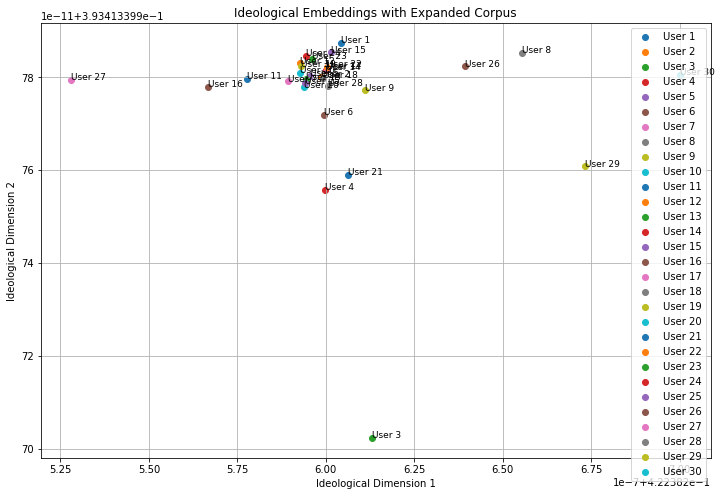

In [28]:
# Visualize the embeddings
plt.figure(figsize=(12, 8))
for i, user_embedding in enumerate(phi):
    plt.scatter(user_embedding[0], user_embedding[1], label=f'User {i + 1}')
    plt.text(user_embedding[0], user_embedding[1], f'User {i + 1}', fontsize=9)


plt.xlabel('Ideological Dimension 1')
plt.ylabel('Ideological Dimension 2')
plt.title('Ideological Embeddings with Expanded Corpus')
plt.legend()
plt.grid(True)
plt.show()
